In [7]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
from scipy.stats import bernoulli
from scipy import stats
import opendp.smartnoise.core as sn
import pandas as pd

In [2]:
formula = lambda p: (-(1-p)*np.log(1-p)-p*np.log(p))
real = formula(0.5)

In [3]:
def f(x):
    return x

In [11]:
# With pymc3
def f_pymc(samples):
    with pm.Model() as model:
        a = pm.Bernoulli("a", 0.5)
        out = pm.Deterministic("out", f(a))
        
        trace = pm.sample(samples)
        
        return mutual_info_regression(trace["a"].reshape(-1,1), trace["out"])[0]

In [12]:
test = [100,1_000,10_000,100_000]
y_pymc = [f_pymc(t) for t in test]

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 19 seconds.


In [4]:
#using random
def f_pm_random(samples):
    a = pm.Bernoulli.dist(0.5).random(size=samples)
    out = np.asarray([f(ai) for ai in a])
    
    return mutual_info_regression(a.reshape(-1,1), out)[0]

In [5]:
test2 = [100,1_000,10_000,100_000, 1_000_000]
y_pm_random = [f_pm_random(t) for t in test2]

In [6]:
from scipy.stats import bernoulli
#using scipy
def f_scipy(samples):
    a = bernoulli.rvs(0.5, size=samples)
    out = np.asarray([f(ai) for ai in a])
    
    return mutual_info_regression(a.reshape(-1,1), out)[0]

In [7]:
y_scipy = [f_pm_random(t) for t in test2]

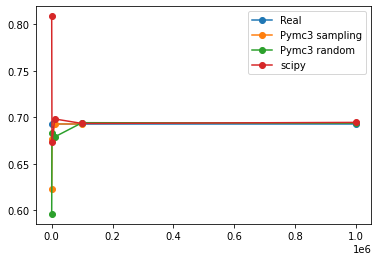

In [17]:
plt.plot([0, test2[-1]],[real,real], "o-", label="Real")
plt.plot(test, y_pymc,"o-", label="Pymc3 sampling")
plt.plot(test2, y_pm_random, "o-",label="Pymc3 random")
plt.plot(test2, y_scipy,"o-", label="scipy")
plt.legend()
plt.show()

In [21]:
print(real, y_pymc[-1], y_pm_random[-2], y_scipy[-2])

0.6931471805599453 0.6928947646740964 0.6942831748317326 0.6934424436822164


In [22]:
%time f_pymc(10_000)
%time f_pm_random(100_000)
%time f_scipy(100_000)

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.


CPU times: user 1.61 s, sys: 578 ms, total: 2.19 s
Wall time: 2.38 s
CPU times: user 922 ms, sys: 15.6 ms, total: 938 ms
Wall time: 943 ms
CPU times: user 922 ms, sys: 0 ns, total: 922 ms
Wall time: 945 ms


0.6943574333410281

In [16]:
%%time
s = 0
for i in range(1_000_000):
    s+=i
print(s)

499999500000
CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 88.6 ms


CPU times: user 13.7 s, sys: 2.16 s, total: 15.9 s
Wall time: 10.8 s
Value of (x,y) that minimises the objective:[0.50322541]
Minimum value of the objective: -0.6945846585868338


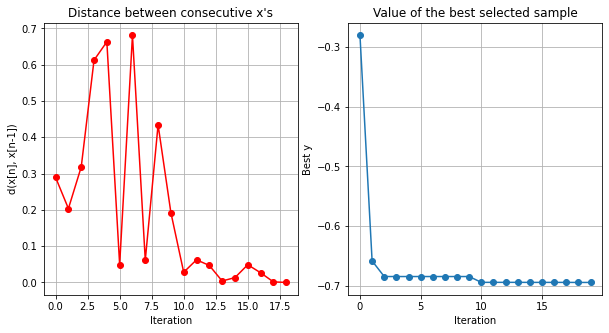

In [33]:
def f_scipy_2(p):
    np.random.seed(12345)
    a = bernoulli.rvs(p, size=100_000)
    out = np.asarray([f(ai) for ai in a])
    
    return -mutual_info_regression(a.reshape(-1,1), out)[0]

INITIAL_DESIGN_NUMDATA = 10
PROGRESS = 0
MAX_ITER = 50
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (0.000001, 0.999999)}
]
Bopt = BayesianOptimization(f=f_scipy_2, domain=domain, 
                         acquisition_type='EI',        # Expected Improvement
                         initial_design_numdata=INITIAL_DESIGN_NUMDATA,
                         exact_feval = True)
%time Bopt.run_optimization(max_iter = MAX_ITER-INITIAL_DESIGN_NUMDATA, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

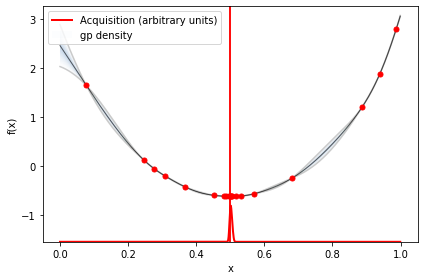

In [34]:
Bopt.plot_acquisition()

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.


CPU times: user 1min 45s, sys: 32.5 s, total: 2min 17s
Wall time: 1min 58s
Value of (x,y) that minimises the objective:[0.52506441]
Minimum value of the objective: -0.6967048557973303


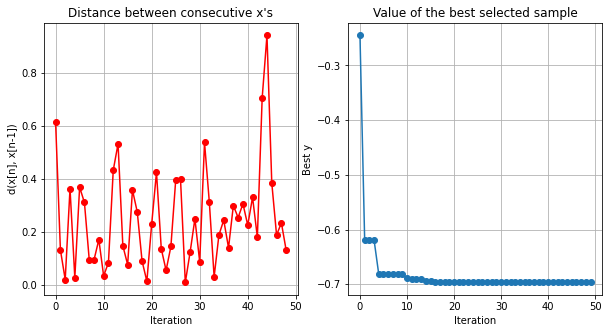

In [30]:
# With pymc3
def f_pymc_2(p):
    np.random.seed(12345)
    p = p[0][0]
    with pm.Model() as model:
        a = pm.Bernoulli("a", p)
        out = pm.Deterministic("out", f(a))
        
        trace = pm.sample(10_000)
        
    return -mutual_info_regression(trace["a"].reshape(-1,1), trace["out"])[0]
INITIAL_DESIGN_NUMDATA = 10
PROGRESS = 0
MAX_ITER = 50
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (0.000001, 0.999999)}
]
Bopt = BayesianOptimization(f=f_pymc_2, domain=domain, 
                         acquisition_type='EI',        # Expected Improvement
                         initial_design_numdata=INITIAL_DESIGN_NUMDATA,
                         exact_feval = True)
%time Bopt.run_optimization(max_iter = MAX_ITER-INITIAL_DESIGN_NUMDATA, eps=1e-8)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()


## RESULTS
PYMC3 Bayesian Optimization = 2min 17 s

Scipy stats = 15.9 s


# Open DB large comparison of time

In [3]:
## opendp program
@theano.compile.ops.as_op(itypes=[tt.lvector,tt.lvector,tt.lvector,
                                  tt.lvector,tt.dvector,tt.lvector,
                                  tt.lscalar],
                          otypes=[tt.dscalar])
def dp_program_pymc3(age,sex,educ,race,income,married,N):
    temp_file='temp.csv'    
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)    

In [4]:
def dp_program_scipy(age,sex,educ,race,income,married,N):
    temp_file='temp.csv'    
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)    

In [31]:
def pm_solution():
    with pm.Model() as model:

        # Dataset size
        N = 10
        N_rv = pm.Constant('N',N)

        # Attribute specs
        age     = pm.DiscreteUniform("age",0,150,shape=N)
        sex     = pm.DiscreteUniform("sex",0,2,shape=N)
        educ    = pm.DiscreteUniform("educ",0,10,shape=N)
        race    = pm.DiscreteUniform("race",0,50,shape=N)
        income  = pm.Normal("income", mu=100,sigma=5,shape=N)
        married = pm.DiscreteUniform("married",0,1,shape=N)

        pm.Deterministic("output",dp_program_pymc3(age,sex,educ,race,income,married,N_rv))

        trace=pm.sample(10000, return_inferencedata = False, cores=1)
        return trace

In [32]:
%time t2 = pm_solution()

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>>Metropolis: [N]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 141 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 2min, sys: 14 s, total: 2min 14s
Wall time: 2min 25s


In [29]:
def scipy_solution(samples):
    N = 10
    
    age = stats.randint(0,150).rvs(size=(samples,N))
    sex = stats.randint(0,2).rvs(size=(samples,N))
    educ = stats.randint(0,10).rvs(size=(samples,N))
    race = stats.randint(0,50).rvs(size=(samples,N))
    income = stats.norm(100,5).rvs(size=(samples,N))
    married = stats.randint(0,1).rvs(size=(samples,N))
    
    output = [dp_program_scipy(a,s,e,r,i,m,N) for a,s,e,r,i,m in zip(age, sex, educ, race, income, married)]
    
    trace = {"age": age, "sex": sex, "income": income, "educ": educ, "race": race, "married": married, "output": output}
    return trace
    
    #res = [(vm,[mutual_info_regression(trace[vm][:,i].reshape(-1,1),trace['income'][:,i]) for i in range(0,1)]) for vm in ['sex','race']]
    #print(res)

In [35]:
%time t = scipy_solution(100_000)

CPU times: user 5min 25s, sys: 47.3 s, total: 6min 12s
Wall time: 6min 25s


In [49]:
np.mean(t["age"])

74.504857

In [34]:
np.mean(t2["age"])

75.014025

In [52]:
real = lambda s1,s2,s3,s4: 0.5*np.log(1+((s1**2)/(s2**2+s3**2+s4**2)))
def normal_scipy(X):
    np.random.seed(12345)
    mus = X[0][:4]
    sigmas = X[0][4:]
    
    alice = stats.norm(mus[0], sigmas[0]).rvs(size=100_000)
    rest1 = stats.norm(mus[1], sigmas[1]).rvs(size=100_000)
    rest2 = stats.norm(mus[2], sigmas[2]).rvs(size=100_000)
    rest3 = stats.norm(mus[3], sigmas[3]).rvs(size=100_000)
    
    out = [sum(db)/len(db) for db in zip(alice, rest1, rest2, rest3)]
    
    return -mutual_info_regression(alice.reshape(-1,1), out, discrete_features=False)[0]

In [55]:
real(1_000,0.0001,0.0001,0.0001)

15.56878950662428

In [56]:
normal_scipy([[1,2,3,4,1_000,0.0001,0.0001,0.0001]])

-10.253651296530094

CPU times: user 2h 36min 37s, sys: 37min 39s, total: 3h 14min 17s
Wall time: 1h 4min 38s
Value of (x,y) that minimises the objective:[  1.51060115 -94.15791929  71.50368695  31.59031648 972.98053251
 144.31009912 190.19849062  97.29358589]
Minimum value of the objective: -1.3672588670360248


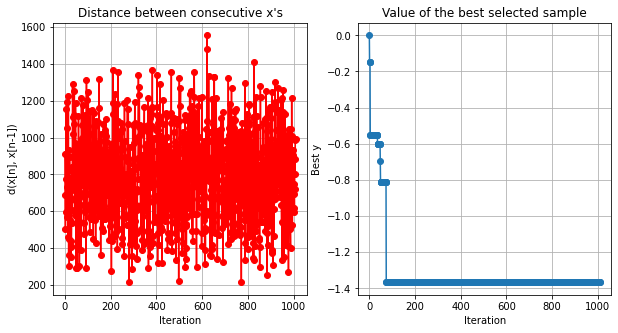

In [71]:
INITIAL_DESIGN_NUMDATA = 10
PROGRESS = 0
MAX_ITER = 500
domain = [
    {"name": "alice_mu", "type": "continuous", "domain": (-100, 100), "dimensionality": 4},
    {"name": "alice_sigma", "type": "continuous", "domain": (0.000001, 1_000), "dimensionality": 4},
]
Bopt = BayesianOptimization(f=normal_scipy, domain=domain, 
                         acquisition_type='EI',        # Expected Improvement
                         initial_design_numdata=INITIAL_DESIGN_NUMDATA,
                         exact_feval = True)
%time Bopt.run_optimization(max_iter=1_000)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

In [63]:
x = Bopt.x_opt
x[5] = 0.0001
normal_scipy([x])

-1.5714844211173187

CPU times: user 22.7 s, sys: 8.39 s, total: 31 s
Wall time: 9.42 s
Value of (x,y) that minimises the objective:[1.e+03 1.e-06 1.e-06 1.e-06]
Minimum value of the objective: -20.173959692612357


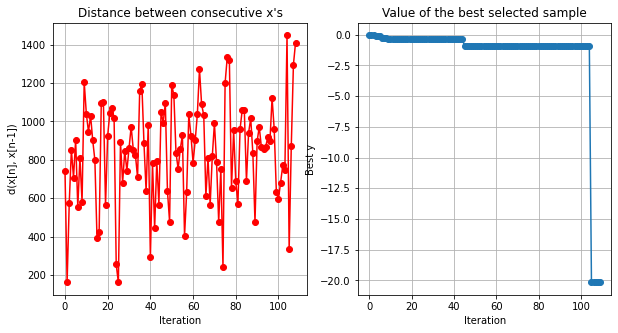

In [70]:
INITIAL_DESIGN_NUMDATA = 10
PROGRESS = 0
MAX_ITER = 500
domain = [
    {"name": "alice_sigma", "type": "continuous", "domain": (0.000001, 1_000), "dimensionality": 4},
]
Bopt = BayesianOptimization(f=lambda x: -real(x[0][0],x[0][1],x[0][2],x[0][3]), domain=domain, 
                         acquisition_type='EI',        # Expected Improvement
                         initial_design_numdata=INITIAL_DESIGN_NUMDATA,
                         exact_feval = True)
%time Bopt.run_optimization(max_iter=100)           # True evaluations, no sample noise)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()